# 17 Qubit Surface Code
Following [Low-distance Surface Codes under Realistic Quantum Noise](https://arxiv.org/pdf/1404.3747.pdf), we aim to implement the distance = 3 17 qubit surface code (mainly as it's less resource intensive than the same distance 25 qubit counterpart). The surface-17 consists of 9 data qubits and 8 ancilla qubits.  The stabilizers for the surface-17 are:
- X Stabilizers:
  - $ X_0 X_1 X_3 X_4 $
  - $ X_1 X_2 $
  - $ X_4 X_5 X_7 X_8 $
  - $ X_6 X_7 $
  
- Z Stabilizers:
  - $ Z_0 Z_3 $
  - $ Z_1 Z_2 Z_4 Z_5 $
  - $ Z_3 Z_4 Z_6 Z_7 $
  - $ Z_5 Z_8 $

As an aside, it may seem like an issue that a $Z$ error on qubits 0 and 3 (as $X$ stabilizers check $Z$ errors!) will lead to the same syndome (and $X$ errors for qubits 1 and 2 etc...). However this is not an issue, as we can correct either $Z_1$ or $Z_3$ as it's a stabilizer.

In [4]:
#Imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, transpile
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import pauli_error
from scipy.sparse import csc_matrix
import pymatching

#Define backends 
simulator = Aer.get_backend('aer_simulator')
state_simulator = Aer.get_backend('statevector_simulator')


In [6]:
def simulate_surface_17(d3_sc, creg):
     """
    Implements stabilizer measurements for a 17-qubit surface code circuit.

    Parameters:
    d3_sc (QuantumCircuit): The quantum circuit representing the 17-qubit surface code.
    creg (ClassicalRegister): The classical register used for measuring the ancilla qubits.

    The function modifies the passed quantum circuit 'd3_sc' in place, without returning anything.
    """
    d3_sc.add_register(creg)
    # Reset all ancillas to |0>
    for i in range(9,17):
        d3_sc.reset(i)
    
    # Implementing the stabilizer measurements
    # X-ancilla qubit 9
    d3_sc.h(9)
    d3_sc.cx(9,1)
    d3_sc.cx(9,2)
    d3_sc.h(9)
    d3_sc.measure(9,creg[0])
    d3_sc.barrier()

    # Z ancilla qubit 10
    d3_sc.cx(0,10)
    d3_sc.cx(3,10)
    d3_sc.measure(10, creg[1])
    d3_sc.barrier()

    # X ancilla qubit 11
    d3_sc.h(11)
    d3_sc.cx(11,0)
    d3_sc.cx(11,1)
    d3_sc.cx(11,3)
    d3_sc.cx(11,4)
    d3_sc.h(11)
    d3_sc.measure(11, creg[2])
    d3_sc.barrier()

    # Z ancilla qubit 12
    d3_sc.cx(1,12)
    d3_sc.cx(2,12)
    d3_sc.cx(4,12)
    d3_sc.cx(5,12)
    d3_sc.measure(12, creg[3])
    d3_sc.barrier()

    # Z ancilla qubit 13
    d3_sc.cx(3, 13)
    d3_sc.cx(4, 13)
    d3_sc.cx(6, 13)
    d3_sc.cx(7, 13)
    d3_sc.measure(13, creg[4])
    d3_sc.barrier()


    # X ancilla qubit 14
    d3_sc.h(14)
    d3_sc.cx(14, 4)
    d3_sc.cx(14, 5)
    d3_sc.cx(14, 7)
    d3_sc.cx(14, 8)
    d3_sc.h(14)
    d3_sc.measure(14, creg[5])
    d3_sc.barrier()

    # Z ancilla qubit 15
    d3_sc.cx(5, 15)
    d3_sc.cx(8, 15)
    d3_sc.measure(15, creg[6])
    d3_sc.barrier()

    # X ancilla qubit 16
    d3_sc.h(16)
    d3_sc.cx(16, 6)
    d3_sc.cx(16, 7)
    d3_sc.h(16)
    d3_sc.measure(16, creg[7])
    d3_sc.barrier()


#Example usage 
num_cycles = 4
qreg = 17
d3_sc = QuantumCircuit(qreg)

# Create and add a classical register for each cycle
classical_regs = [ClassicalRegister(8, f'c{cycle}') for cycle in range(num_cycles)]

# Run the simulation for each cycle with its corresponding classical register
for cycle in range(num_cycles):
    simulate_surface_17(d3_sc, classical_regs[cycle])
    

# Execute the circuit and get the result
job = execute(d3_sc, simulator, shots=1)
result = job.result().get_counts()

# Extract the binary string (assuming there is only one key in the dictionary)
print(result)

{'10000001 10000001 10000001 10000001': 1}


So if we  were to run this and measure the ancilla qubits evert cycle, we would see the state will collapse to any one of the eigenstates of the stabilizers. Then, in the abscence of errors, this state will remain throughout all cycles, and the ancilla measurements will be the same. With the presence of errors, the error will causes a unique change in the ancilla readout/syndrome measurement.

## Decoding with PyMatching
We need some way to decode all the possible error syndromes. For this, we will experiment with [PyMatching](https://github.com/oscarhiggott/PyMatching) (although it remains to be seen how compatible this is with qiskit).
##### Simple Example

We must create $H$, a parity check matrix. Each row of the matrix $H$ represents a different stabilizer (a parity check).
Each column represents a different qubit.
The matrix element $H_{i,j}$ is set to 1 if the $i$-th stabilizer acts on the 
$j$-th qubit (i.e., if the qubit is part of that stabilizer), and 0 otherwise. Read about it in more detail in this PyMatching [Toric Code Example](https://pymatching.readthedocs.io/en/latest/toric-code-example.html) and section III B [here](https://arxiv.org/pdf/1404.3747.pdf). Here is a simple example for the 3 qubit code (recalling the stabilizers are $Z_1Z_2$ and $Z_2Z_3$). 

In [7]:
H = csc_matrix([[1, 1, 0],
                 [0, 1, 1]])

weights = np.array([1, 1, 1])   # Set arbitrary weights for illustration
matching = pymatching.Matching(H, weights=weights)
prediction = matching.decode(np.array([1, 1]))
print(prediction)  

[0 1 0]


Let's now create the H matrix for the surface code. We'll have to create two matricies $H_x$ and $H_z$, for the measurement of the $X$ stabilizers and $Z$ stabilizers. For the surface code we have our queiscient state (which is selected from many possible quiescent states), so we don't necessarily know the values of the stabilizer measurements. Therefore, we need to track the **changes** in stabilizer/ancilla measurements between each cycles. The change in the measurement value still allows us to determine where the error has occured.

In [8]:
H_x = np.array([
    [0, 1, 1, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 0, 1, 1],
    [0, 0, 0, 0, 0, 0, 1, 1, 0]
])



H_z = np.array([  
    [1, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1, 1, 0, 0, 0],
    [0, 0, 0, 1, 1, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 1]
])

weights = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1])   # Set arbitrary weights for illustration

#Example for X stabilizers
xmatching = pymatching.Matching(H_x, weights = weights)

xprediction = xmatching.decode(np.array([0, 1, 0, 0]))
print("Z Errors: ", xprediction)  

zmatching = pymatching.Matching(H_z, weights = weights)

zprediction = zmatching.decode(np.array([1, 1, 0, 1]))
print("X Errors: ", zprediction)  

Z Errors:  [1 0 0 0 0 0 0 0 0]
X Errors:  [1 0 0 0 0 1 0 0 0]


In [9]:
def decode_errors(results):
    """
    Decodes errors from the (qiskit) results of a measurement.

    Parameters:
    results (dict): A dictionary containing the results of a quantum circuit simulation.
                    The keys are the binary strings representing the measurement outcomes
                    (error syndromes), and the values are their corresponding counts.

    The function performs the following steps:
    - Extracts the binary string representing the error syndromes.
    - Initializes parity check matrices for X and Z errors.
    - Splits the binary string into cycles and computes the difference in syndromes between cycles.
    - Uses the pymatching library to decode these differences and identify possible errors.
    - Constructs a report of identified X and Z errors for each cycle.

    Returns:
    list: A list of dictionaries, each containing the cycle number and lists of identified X and Z errors.
    """
    H_x = np.array([
        [0, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 0]
    ])

    H_z = np.array([
        [1, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 1]
    ])

    weights = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1])

    # Extract the binary string
    binary_str = next(iter(results)).replace(" ", "")[::-1] #Due to qiskits little endian
    n_cycles = len(binary_str) // 8

    if len(binary_str) % 8 != 0:
        raise ValueError("Binary string length is not a multiple of 8 after removing spaces. The 17 qubit surface code measures 8 stabilizers.")

    # Initialize pymatching matchers
    xmatching = pymatching.Matching(H_x, weights=weights)
    zmatching = pymatching.Matching(H_z, weights=weights)

    error_reports = []

    for cycle in range(n_cycles - 1):
        start1 = cycle * 8
        start2 = (cycle + 1) * 8
        cycle1 = binary_str[start1:start1 + 8]
        cycle2 = binary_str[start2:start2 + 8]

        # Extract syndromes and calculate differences
        X_syndromes_cycle1 = [int(cycle1[i]) for i in [0, 2, 5, 7]]
        Z_syndromes_cycle1 = [int(cycle1[i]) for i in [1, 3, 4, 6]]
        X_syndromes_cycle2 = [int(cycle2[i]) for i in [0, 2, 5, 7]]
        Z_syndromes_cycle2 = [int(cycle2[i]) for i in [1, 3, 4, 6]]

        Xdifference = [0 if X_syndromes_cycle1[i] == X_syndromes_cycle2[i] else 1 for i in range(4)]
        Zdifference = [0 if Z_syndromes_cycle1[i] == Z_syndromes_cycle2[i] else 1 for i in range(4)]

        # Decode the differences
        xprediction = xmatching.decode(Xdifference)
        zprediction = zmatching.decode(Zdifference)

        cycle_errors = {'cycle': cycle + 1, 'X_error': [], 'Z_error': []}

        # Identify X and Z errors
        for i, x in enumerate(xprediction):
            if x == 1:
                cycle_errors['Z_error'].append(i) #As X stabilizers pick up Z errors

        for i, z in enumerate(zprediction):
            if z == 1:
                cycle_errors['X_error'].append(i) #As X stabilizers pick up Z errors

        error_reports.append(cycle_errors)

    return error_reports

We can build on our previous case where we just measured the ancilla qubits by introducing some errors/test cases and decoding them.  Below, we are able to diagnoze 2 $Z$ errors and 2 $X$ errors during a single cycle.

In [10]:
num_cycles = 4
qreg = 17
d3_sc = QuantumCircuit(qreg)

# Create and add a classical register for each cycle
classical_regs = [ClassicalRegister(8, f'c{cycle}') for cycle in range(num_cycles)]

# Run the simulation for each cycle with its corresponding classical register
for cycle in range(num_cycles):
    simulate_surface_17(d3_sc, classical_regs[cycle])

    if cycle == 0:
        d3_sc.x(0)
        d3_sc.x(5)
        d3_sc.z(2)
        d3_sc.z(7)
    

# Execute the circuit and get the result
job = execute(d3_sc, simulator, shots=1)
result = job.result().get_counts()

# Extract the binary string (assuming there is only one key in the dictionary)
print(result)

err_report = decode_errors(result)

print(err_report)

{'11101111 11101111 11101111 00000100': 1}
[{'cycle': 1, 'X_error': [0, 5], 'Z_error': [2, 7]}, {'cycle': 2, 'X_error': [], 'Z_error': []}, {'cycle': 3, 'X_error': [], 'Z_error': []}]


### Applying Corrections
Qiskit doesn't seem to offer much in the way of conditional gates based on mid-circuit measurements, aside from `c_if`, which we can't use as we're using the classical registers to decode the error syndrome, so there doesn't really seem like a neat way of implementing this result back into a `c_if` statement. Instead, we will use `error_report` at the end of $n$ cycles to apply corrections to the state (i.e. based on our decoded information). It's also worth noting, if the same error occurs an even number of times, we don't need to correct it as it has effectively corrected itself.

In [11]:
from collections import Counter

def apply_error_corrections(qc, error_reports):
    """
    Apply error corrections to the quantum circuit based on error reports.
    Corrects a qubit if it has an odd number of errors.

    Parameters:
    qc (QuantumCircuit): The quantum circuit to apply corrections to.
    error_reports (list): A list of dictionaries containing error reports for each cycle.
    
    Returns:
    QuantumCircuit: The quantum circuit with applied error corrections.
    """
    x_errors = []
    z_errors = []

    # Collect all errors
    for report in error_reports:
        x_errors.extend(report['X_error'])
        z_errors.extend(report['Z_error'])

    # Count occurrences and filter out even occurrences
    x_error_counts = Counter(x_errors)
    z_error_counts = Counter(z_errors)

    # Apply X corrections for odd occurrences
    for qubit, count in x_error_counts.items():
        if count % 2 != 0:  # Odd count
            qc.x(qubit)

    # Apply Z corrections for odd occurrences
    for qubit, count in z_error_counts.items():
        if count % 2 != 0:  # Odd count
            qc.z(qubit)

    return qc

Let's now complete the final step of the puzzle by applying correction to our manually inputted errors. We can run `d3_sc.draw('mpl')` to see these corrections.

In [12]:
num_cycles = 3
qreg = 17
d3_sc = QuantumCircuit(qreg)

# Create and add a classical register for each cycle
classical_regs = [ClassicalRegister(8, f'c{cycle}') for cycle in range(num_cycles)]

# Run the simulation for each cycle with its corresponding classical register
for cycle in range(num_cycles):
    simulate_surface_17(d3_sc, classical_regs[cycle])

    if cycle == 0:
        d3_sc.x(0)
        d3_sc.x(5)
        d3_sc.z(2)

    if cycle ==1:
        d3_sc.x(0) #These correct themselves
        d3_sc.z(2)

    if cycle == 2:
        d3_sc.z(2) 
    

# Execute the circuit and get the result
job = execute(d3_sc, simulator, shots=1)
result = job.result().get_counts()

#Decode the errors
err_report = decode_errors(result)

print(err_report)

#Apply corrections
apply_error_corrections(d3_sc, err_report)

# d3_sc.draw('mpl')

[{'cycle': 1, 'X_error': [0, 5], 'Z_error': [2]}, {'cycle': 2, 'X_error': [0], 'Z_error': [2]}]


## Bringing it all together
So now we have all the tools we need, all we need to do is bring it together. What will this involve?
- Add a noise model
- Check how well the code performs, e.g. logical error rate vs physical error rate.

For now, let's just create a simple Pauli error noise model. This will just apply an $X$, $Z$ or a combination ($Y$) randomly to the 9 data qubits, given a single qubit error probability.

In [13]:
import random
def apply_random_pauli_errors(circuit, prob):
    """
    Apply random X, Y, or Z gate errors to each qubit in the given circuit with a given probability.

    Args:
    - circuit (QuantumCircuit): The quantum circuit to which the errors will be applied.
    - prob (float): The probability with which an error occurs on each qubit.

    Returns:
    - QuantumCircuit: The modified quantum circuit.
    """
    num_qubits = circuit.num_qubits

    # Ensure that the circuit has at least 9 qubits
    if num_qubits < 9:
        raise ValueError("Circuit must have at least 9 qubits")

    for qubit_index in range(9):  # Iterate over qubits 0 to 8
        # Generate a random number to decide if the error should be applied to this qubit
        if random.random() < prob:
            # Randomly choose between an X, Y, or Z gate
            gate_choice = random.choice(['x', 'y', 'z'])

            # Apply the chosen gate to the qubit
            getattr(circuit, gate_choice)(qubit_index)

    return circuit

#### Qiskit's Density Matricies & State Vectors
To allow us to compare initial and final states (to allow us to calculate logical error rate), we would ideally use qiskits `save_density_matrix` function along with `state_fidelity`. However a $2^{17} \times 2^{17}$ density matrix is very resource intensive, so we have to just work with the statevector at the moment instead.

In [16]:
# Example
from qiskit.quantum_info import state_fidelity, Statevector

qc = QuantumCircuit(2)

qc.h(0)
s = Statevector(qc)

qc2 = QuantumCircuit(2)
s2 = Statevector(qc2)

fidelity = state_fidelity(s , s2)

print("State vector 1: ", s)
print("State vector 2: ", s2)
print("Fidelity: ", round(fidelity, 2))

State vector 1:  Statevector([0.70710678+0.j, 0.70710678+0.j, 0.        +0.j,
             0.        +0.j],
            dims=(2, 2))
State vector 2:  Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2))
Fidelity:  0.5


We can now incoportate this to allow us to compare the initial state and final state following $n$ cycles.

In [17]:
def run_simulation(num_shots, num_cycles, p_err):
    """
    Runs a simulation of the 17 qubit surface code and calculates the average fidelity.

    Parameters:
    num_shots (int): The number of times the simulation is run.
    num_cycles (int): The number of error correction cycles in each simulation.
    p_err (float): The probability of a Pauli error (X, Z or Y) occurring in each cycle.
    
    Returns:
    float: The average fidelity over all simulation runs.
    """
    fidelities = []
    simulator = Aer.get_backend('aer_simulator')
    state_simulator = Aer.get_backend('statevector_simulator')

    # error = pauli_error([('X', 0.5 * p_err), ('Z', 0.5 * p_err), ('I', 1.0 - p_err)])
    
    for shot in range(num_shots):
        qreg = 17
        d3_sc = QuantumCircuit(qreg)
        classical_regs = [ClassicalRegister(8, f'c{cycle}') for cycle in range(num_cycles+1)]

        for cycle in range(num_cycles):
            simulate_surface_17(d3_sc, classical_regs[cycle])

            if cycle == 0:  # Cycle 0 is state preparation
                d3_sc.save_statevector(label='initial_state')

            #==========================================
            # if cycle != num_cycles - 1:
            #     for i in range(0, 9):
            #         d3_sc.append(error, [i])
            if cycle != num_cycles - 1:
                apply_random_pauli_errors(d3_sc, p_err)

            #==========================================



        job = execute(d3_sc, simulator, shots=1)
        result = job.result().get_counts()
        #----------------------------------------------
        # print(result)
        #----------------------------------------------

        err_report = decode_errors(result)
        #----------------------------------------------
        # print(err_report)
        #----------------------------------------------

        apply_error_corrections(d3_sc, err_report)
        #----------------------------------------------
        #Cycle through once more after applying corrections (?) <----- This is to put ancillas back into desired 'quiescent state' 
        simulate_surface_17(d3_sc,classical_regs[num_cycles])
        #----------------------------------------------

        #Save the final state statevector
        d3_sc.save_statevector(label='final_state')

        #Run the statevector jobs
        transpiled_qc = transpile(d3_sc, state_simulator)
        sv_job = state_simulator.run(transpiled_qc)
        sv_result = sv_job.result()
        initial_state = sv_result.data()['initial_state']
        final_state = sv_result.data()['final_state']

        #Calculate fidelity
        fidelity = state_fidelity(initial_state, final_state)
        fidelities.append(fidelity)
        
    average_fidelity = sum(fidelities) / num_shots
    return average_fidelity

In [18]:
import time
# Example usage of the function
num_shots = 100
num_cycles = 2
p_err = 0.01
start_time = time.time()
average_fidelity = run_simulation(num_shots, num_cycles, p_err)
end_time = time.time()


print(f"Time taken = {end_time - start_time} seconds")
print("Average fidelity across all shots: ", round(average_fidelity, 3))

Time taken = 14.137807846069336 seconds
Average fidelity across all shots:  1.0


Time taken = 260.4806661605835 seconds


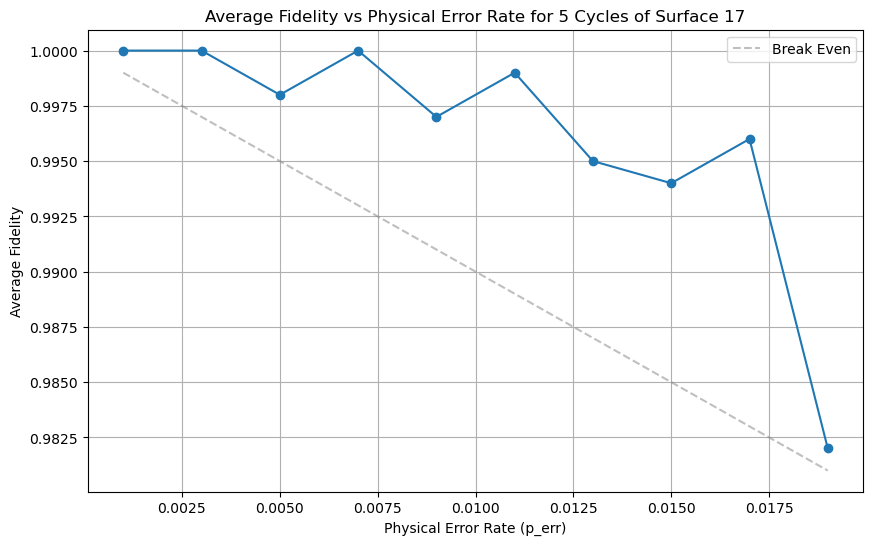

In [19]:
num_shots = 1000
num_cycles = 5
p_err_values = np.arange(0.001, 0.02, 0.002)  # p_err from 0.001 to 0.02 in steps of 0.001
average_fidelities = []

for p_err in p_err_values:
    start_time = time.time()
    average_fidelity = run_simulation(num_shots, num_cycles, p_err)
    end_time = time.time()

    # print(f"p_err = {round(p_err,2)}, Average Fidelity = {round(average_fidelity, 3)}")
    
    average_fidelities.append(average_fidelity)


print(f"Time taken = {end_time - start_time} seconds")

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(p_err_values, average_fidelities, marker='o')
plt.plot(p_err_values, 1 - p_err_values, linestyle='--', alpha=0.5, color='gray', label='Break Even')
plt.title(f"Average Fidelity vs Physical Error Rate for {num_cycles} Cycles of Surface 17")
plt.xlabel("Physical Error Rate (p_err)")
plt.ylabel("Average Fidelity")
plt.grid(True)
plt.legend()
plt.show()

#### Not currently compatible with qiskits quantum channel
Currently, when trying to implement qiskits own quantum channels (e.g. `error = pauli_error([('X', 0.5 * p_err), ('Z', 0.5 * p_err), ('I', 1.0 - p_err)])`), this messes up the fidelity, and causes a different final state, even when no errors occur. This may be due to the method of executing the statevectors...

Another frustrating issue is that qiskit doesn't (seem to) allow the execution of mid-circuit measurements during the computation, as measurements after this will 're-write' the previous measurement results (so if there is any probabilistic state collapse, the state could collapse to one state during the first measurement, then a different one during the second measurement). This makes it hard to extract error syndromes during the computation, and as we've done, we have to extract all error syndromes at the end of $n$
 cycles.